Imports

In [2]:
# imports
import sklearn 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.covariance import EmpiricalCovariance

Model

In [3]:
class Solver:
    
    def __init__(self, data):
        
        self.data = data
    
        # parameter computation
        self.expected_returns = self.estimateMUCAPM(self.data) 
        self.cov_matrix = self.estimateVSHRINK(self.data)      
    
        # Portfolios
        self.tan_robust = self.tanRobust()
        self.gmv_robust = self.gmvRobust()
        
        
    # Portfolios computation
    def tanRobust(self):
        
        weights = self.tanP(self.expected_returns, self.cov_matrix)
        
        return weights
    
    def gmvRobust(self):
        
        weights = self.gmvP(self.cov_matrix)
        
        return weights
    
    
    ##############################################################################
    #########################    helper methods   ################################
    
    def normalizeData(self, data):
        return sklearn.preprocessing.normalize(data)
    
    def estimateMUCAPM(self, data):
        returns = EmpiricalCovariance().fit(data).location_
        return returns
    
    def estimateVSHRINK(self, data):
        cov_matrix = EmpiricalCovariance().fit(data).covariance_
        return cov_matrix
    
    def tanP(self, mucapm, vshrink):
        w = np.linalg.inv(vshrink) @ mucapm
        w /= np.sum(w)
        return w
    
    def gmvP(self, vshrink):
        w = np.linalg.inv(vshrink) @ np.ones(len(vshrink))
        w /= np.sum(w)
        return w
           
    def evaluatePortfolio(self, weights, data_evaluate):
        evaluate = {}
        w = weights.reshape((-1))
        V = self.estimateVSHRINK(data_evaluate)
        mu = self.estimateMUCAPM(data_evaluate)
        er = mu.T @ w
        sig = np.sqrt(w.T @ V @ w)
        var = w.T @ V @ w
        sharpe = (mu.T @ w - 0)/(np.sqrt(w.T @ V @ w))
        evaluate['ER'] = er
        evaluate['SIGMA'] = sig
        evaluate['VAR'] = var
        evaluate['SHARPE'] = sharpe
        return evaluate
    
    def getEF(self, x, y, data):
        t = np.arange(0,1.1,0.01)
        sig = np.zeros_like (t) * np.nan
        er = np.zeros_like (t) * np.nan
        for i in np.arange(len(t)):
            w = t[i] * x + (1-t[i]) * y
            sig[i] = self.evaluatePortfolio(w, data) ['SIGMA']
            er[i] = self.evaluatePortfolio(w, data) ['ER']    
        return sig, er
    
    def plotIn_sample(self, train_data):
        
        mu_capm = self.estimateMUCAPM(train_data)
        vshrink = self.estimateVSHRINK(train_data)
        t_ = self.tanP(mu_capm , vshrink)
        g_ = self.gmvP(vshrink)
        
        sig, er = self.getEF(t_, g_, train_data)
        
        plt.figure(figsize=(8, 7))
        
        plt.scatter(self.evaluatePortfolio(t_, train_data)['SIGMA'], self.evaluatePortfolio(t_, train_data)['ER'], marker='*', color = 'red',label='TAN')
        plt.scatter(self.evaluatePortfolio(g_, train_data)['SIGMA'], self.evaluatePortfolio(g_, train_data)['ER'], marker='^', color = 'red',label = 'GMV')
        
        plt.plot(sig, er, label = 'EF')
        
        plt.legend()
        plt.title('Risk-Return Diagram (In-sample Analysis)')
        plt.xlabel('$\sigma$ (%)')
        plt.ylabel('E[r] (%)')
        plt.show()
        
    def plotOut_sample(self, train_data, test_data):
        
        mu_capm_train = self.estimateMUCAPM(train_data)
        vshrink_train = self.estimateVSHRINK(train_data)
        t_train = self.tanP(mu_capm_train, vshrink_train)
        g_train = self.gmvP(vshrink_train)
        
        mu_capm_test = self.estimateMUCAPM(test_data)
        vshrink_test = self.estimateVSHRINK(test_data)
        t_test = self.tanP(mu_capm_test , vshrink_test)
        g_test = self.gmvP(vshrink_test)
        
        sig, er = self.getEF(t_test, g_test, test_data)
        sig_estimate, er_estimate = self.getEF(t_train, g_train, train_data)
        sig_realized, er_realized =self.getEF(t_train, g_train, test_data)
        
        plt.figure(figsize=(8, 7))
        
        plt.scatter(self.evaluatePortfolio(t_train, test_data)['SIGMA'], self.evaluatePortfolio(t_train, test_data)['ER'], marker='*', color = 'black',label = 'TAN (from train)')
        plt.scatter(self.evaluatePortfolio(g_train, test_data)['SIGMA'], self.evaluatePortfolio(g_train, test_data)['ER'], marker='^', color = 'black',label = 'GMV (from train)')
        
        plt.scatter(self.evaluatePortfolio(t_test, test_data)['SIGMA'], self.evaluatePortfolio(t_test, test_data)['ER'], marker='*', color = 'red',label='TAN (from test)')
        plt.scatter(self.evaluatePortfolio(g_test, test_data)['SIGMA'], self.evaluatePortfolio(g_test, test_data)['ER'], marker='^', color = 'red',label = 'GMV (from test)')

    
        plt.plot(sig, er, label = 'True EF')
        plt.plot(sig_estimate, er_estimate, 'k--', label = 'Estimated EF')
        plt.plot(sig_realized, er_realized, '--', label = 'Realized EF')
        
        plt.legend()
        plt.title('Risk-Return Diagram (Out-of-sample Analysis)')
        plt.xlabel('$\sigma$ (%)')
        plt.ylabel('E[r] (%)')
        plt.show()
        

Results and Visualization/Evaluation

In-Sample Analysis


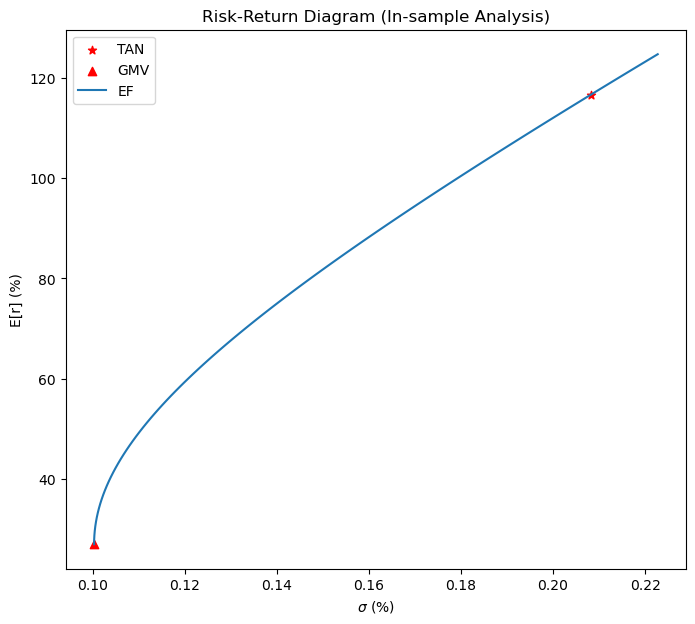

Out-Sample Analysis


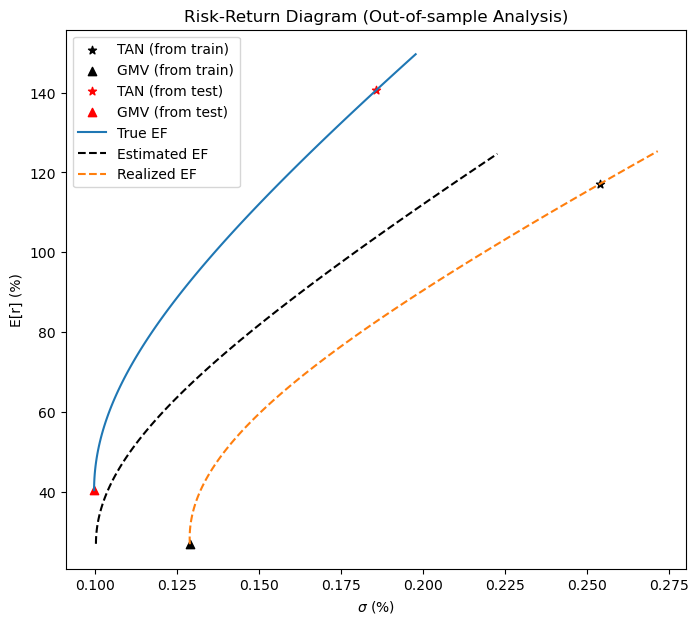

In [3]:
def main():
    
    data = pd.read_csv('data.csv')
    train_data = data.iloc[:200, :]
    test_data = data.iloc[200:, :]
    
    Portfolio = Solver(data)
    
    # Portfolio Weights
    TAN_robust = Portfolio.tan_robust
    GMV_robust = Portfolio.gmv_robust
    
    # Visualizations
    print('In-Sample Analysis')
    Portfolio.plotIn_sample(train_data)
    print('Out-Sample Analysis')
    Portfolio.plotOut_sample(train_data, test_data)


    
# main loop
if __name__ == "__main__":
    
    main()
    

In [4]:
# If u having trouble with the if name main, u can just access stuff using this format

# here we first set up the data
data = pd.read_csv('data.csv')
train_data = data.iloc[:200, :]
test_data = data.iloc[200:, :]

# we are passing in data for the Solver to solve and compute the 2 portfolios
Portfolio = Solver(data) 
    
# after we pass in the data, we can then get the Portfolio Weights using this
TAN_robust = Portfolio.tan_robust
GMV_robust = Portfolio.gmv_robust

## here we print TAN_robust portfolio
print(TAN_robust)

[ 2.90688866e-04 -2.62609259e-03  9.99632880e-01 -3.09923201e-03
  1.69714657e-03 -1.56695426e-04 -2.19843321e-04 -1.44062595e-03
  8.05432492e-04 -4.70224417e-04  4.88057647e-03  2.53961111e-03
 -2.13269338e-03 -1.48921357e-03 -6.12348931e-04 -2.88232802e-03
  3.47533741e-03  4.36560537e-04 -1.42262228e-03  6.83970778e-03
 -2.11020643e-03 -6.53161064e-04  1.84130868e-03 -1.11876832e-03
 -2.62932889e-03  1.31388835e-03 -5.24259382e-04 -3.29633870e-03
 -1.17837954e-03  1.21552859e-03  1.01513146e-03 -6.94471266e-04
  2.40162639e-04 -1.40700338e-03  2.72656025e-04  2.59307791e-03
 -3.31038334e-04 -3.94816617e-03  6.01751047e-03 -5.39437833e-04
 -2.69345847e-03 -5.60362059e-04 -3.82711629e-04  1.36166902e-03
 -9.58583557e-04  3.10872088e-03]


In [5]:
## here we print TAN_robust portfolio
print(GMV_robust)

[ 1.89153155e-04  3.78102362e-02  9.99285901e-01 -2.21003742e-03
 -5.21193237e-04  2.97715965e-04 -2.00770102e-03 -1.60586125e-03
  1.17212299e-03 -1.62191097e-03  2.18220694e-03 -2.18111833e-04
 -1.39827580e-03 -1.47904920e-03 -2.25875947e-03 -6.18492004e-03
  2.03876939e-03 -6.06223289e-04 -3.31366636e-04  4.78889716e-03
 -2.59702174e-03 -2.93395013e-03  6.25410925e-04  6.44347588e-05
 -4.62211228e-03  1.52717682e-04 -8.40380050e-04 -4.01764877e-05
 -1.17989967e-03  8.30730839e-04  1.04655576e-03 -9.29653567e-04
 -3.31654679e-03 -1.88824907e-03 -4.41665070e-03  9.12767695e-04
 -4.42818258e-03 -4.07436891e-03  1.81944543e-03  1.14809641e-04
 -2.14758058e-03 -7.36490274e-04 -1.16724391e-03  2.26706483e-03
 -4.30476598e-03  4.46774243e-03]
